In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4.5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12

# Show less scientific notation when displaying pandas
pd.set_option("display.float_format", lambda x: f"{x:0.6f}")

In [7]:
tables_dir = os.path.join("..", "results", "tables")
csv_path = os.path.join(tables_dir, "exp12_shape_texture_pier_separated.csv")

df = pd.read_csv(csv_path)
print(f"Loaded shape/texture PIER table from: {csv_path}")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nUnique shape variants:", df["ShapeVariant"].unique())
print("Unique contexts:", df["ContextLabel"].unique())
print("Unique target models:", df["TargetModel"].unique())


Loaded shape/texture PIER table from: ..\results\tables\exp12_shape_texture_pier_separated.csv
  ContextType     ContextLabel        TargetModel             Group     Dose  \
0     dataset  texture_natural           ResNet50      Standard CNN 0.000000   
1     dataset  texture_natural     EfficientNetB0      Standard CNN 0.000000   
2     dataset  texture_natural       ConvNeXtTiny      Standard CNN 0.000000   
3     dataset  texture_natural            ViT_B16      Standard CNN 0.000000   
4     dataset  texture_natural  ShapeResNet50_SIN  Shape-biased CNN 0.000000   

   MeanPIER  StdPIER  NumEvalPoints  NumFitPoints  ContextRawSize ShapeVariant  
0  0.091702 0.054966            400           400             800            A  
1  0.055704 0.045583            400           400             800            A  
2  0.032443 0.027825            400           400             800            A  
3  0.031437 0.027249            400           400             800            A  
4  0.167685 0.08445

In [8]:
model_order = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",          # A: SIN only
    "ShapeResNet50_SININ",        # B: SIN + IN
    "ShapeResNet50_ShapeResNet",  # C: SIN+IN then finetuned on IN
]

variant_order = ["A", "B", "C"]  # ShapeVariant

color_map_models = {
    "ResNet50": "tab:orange",
    "EfficientNetB0": "tab:green",
    "ConvNeXtTiny": "tab:red",
    "ViT_B16": "tab:purple",
    "ShapeResNet50_SIN": "tab:blue",
    "ShapeResNet50_SININ": "tab:brown",
    "ShapeResNet50_ShapeResNet": "tab:pink",
}

color_map_contexts = {
    "texture_natural": "tab:gray",
    "shape_bias": "tab:cyan",
}

pretty_context = {
    "texture_natural": "Natural (texture-rich)",
    "shape_bias": "Shape-biased (cue-conflict)",
}

pretty_variant = {
    "A": "ShapeResNet50_SIN (A: SIN only)",
    "B": "ShapeResNet50_SININ (B: SIN+IN)",
    "C": "ShapeResNet50_ShapeResNet (C: SIN+IN→IN)",
}

def order_models(sub_df: pd.DataFrame) -> pd.DataFrame:
    sub = sub_df.copy()
    order_dict = {m: i for i, m in enumerate(model_order)}
    sub["__order"] = sub["TargetModel"].map(order_dict).fillna(len(model_order)).astype(int)
    sub = sub.sort_values("__order")
    sub = sub.drop(columns=["__order"])
    return sub


In [9]:
# Compute δPIER = shape_bias - texture_natural (aggregated by ShapeVariant + TargetModel)
pivot = (
    df.pivot_table(
        index=["ShapeVariant", "TargetModel"],
        columns="ContextLabel",
        values="MeanPIER",
        aggfunc="mean",
    )
    .reset_index()
)

# If both contexts exist, compute the difference
if set(["texture_natural", "shape_bias"]).issubset(pivot.columns):
    pivot["DeltaPIER"] = pivot["shape_bias"] - pivot["texture_natural"]
else:
    print("Warning: missing one of the contexts in pivot table.")

pivot = order_models(pivot)
pivot.head()


ContextLabel,ShapeVariant,TargetModel,shape_bias,texture_natural,DeltaPIER
2,A,ResNet50,0.097111,0.091702,0.005409
7,B,ResNet50,0.097110,0.091707,0.005403
12,C,ResNet50,0.097111,0.091708,0.005403
6,B,EfficientNetB0,0.070341,0.051121,0.019220
11,C,EfficientNetB0,0.072952,0.052296,0.020656


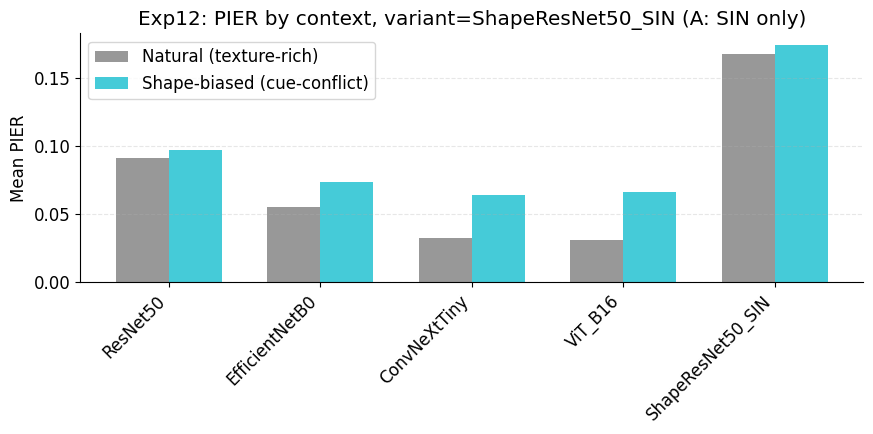

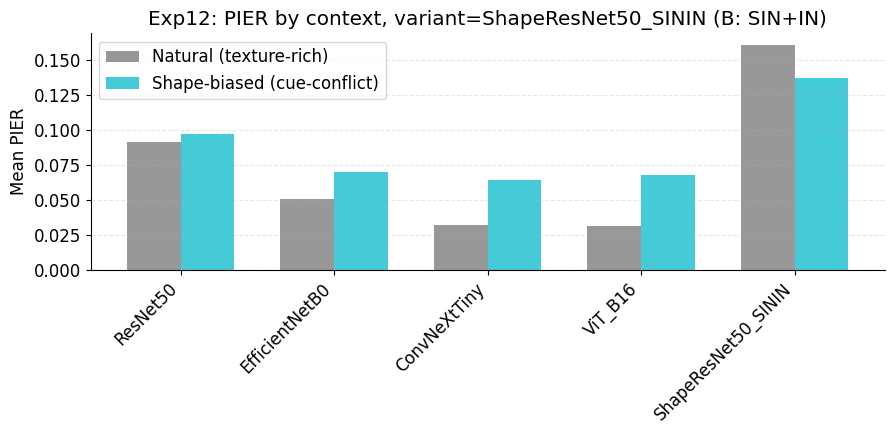

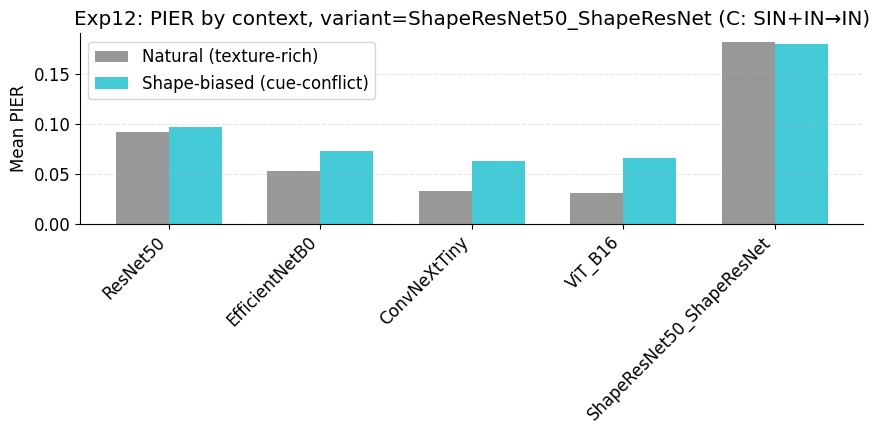

In [10]:
def plot_pier_by_context_for_variant(df: pd.DataFrame, variant: str):
    """对某个 ShapeVariant（A/B/C），画每个模型在两个 context 下的 MeanPIER 对比。"""
    """For a given ShapeVariant (A/B/C), plot MeanPIER by context for each model."""
    sub = df[df["ShapeVariant"] == variant].copy()
    if sub.empty:
        print(f"No rows found for ShapeVariant={variant}")
        return
    
    # Aggregate by model + context (just in case)
    agg = (
        sub.groupby(["TargetModel", "ContextLabel"])["MeanPIER"]
        .mean()
        .reset_index()
    )
    agg = order_models(agg)

    models = agg["TargetModel"].unique().tolist()
    contexts = ["texture_natural", "shape_bias"]
    
    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9, 4.5))

    for i, ctx in enumerate(contexts):
        ctx_data = agg[agg["ContextLabel"] == ctx]
        # Ensure order aligns with models
        ctx_data = ctx_data.set_index("TargetModel").reindex(models)
        heights = ctx_data["MeanPIER"].values

        offset = (-0.5 + i) * width
        ax.bar(
            x + offset,
            heights,
            width=width,
            label=pretty_context.get(ctx, ctx),
            color=color_map_contexts.get(ctx, None),
            alpha=0.8,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.set_ylabel("Mean PIER")
    ax.set_title(f"Exp12: PIER by context, variant={pretty_variant.get(variant, variant)}")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()


for v in variant_order:
    plot_pier_by_context_for_variant(df, v)


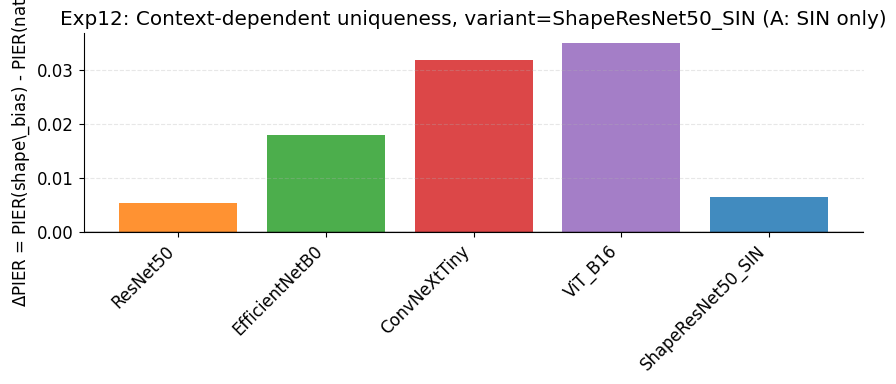

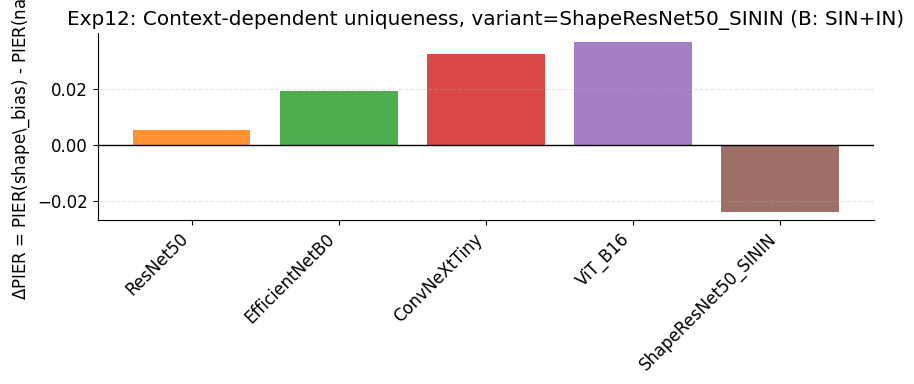

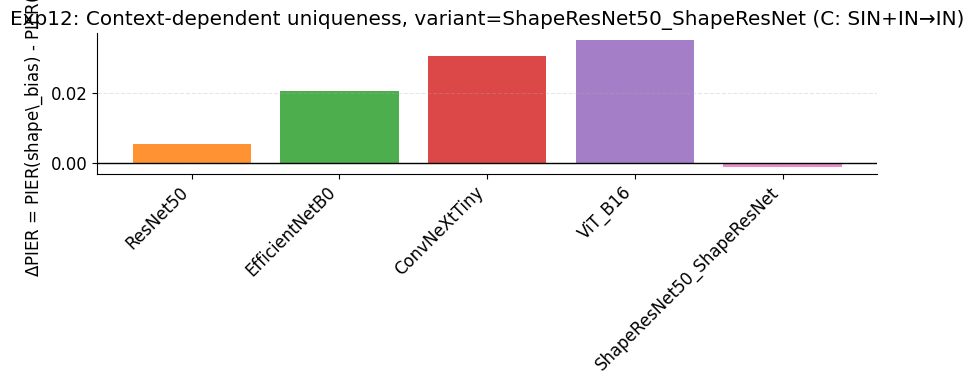

In [11]:
def plot_delta_pier_by_variant(pivot: pd.DataFrame):
    """Using the DeltaPIER from the pivot table above, plot ΔPIER for each model in A/B/C.
       This plot is especially useful to show: who becomes more unique in the shape-biased context.
    """
    if "DeltaPIER" not in pivot.columns:
        print("DeltaPIER not found; run the pivot cell first.")
        return

    for v in variant_order:
        sub = pivot[pivot["ShapeVariant"] == v].copy()
        if sub.empty:
            continue
        sub = order_models(sub)

        models = sub["TargetModel"].tolist()
        deltas = sub["DeltaPIER"].values

        fig, ax = plt.subplots(figsize=(9, 4))
        x = np.arange(len(models))

        colors = [color_map_models.get(m, "tab:gray") for m in models]
        ax.bar(x, deltas, color=colors, alpha=0.85)

        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha="right")
        ax.set_ylabel(r"$\Delta$PIER = PIER(shape\_bias) - PIER(natural)")
        ax.set_title(f"Exp12: Context-dependent uniqueness, variant={pretty_variant.get(v, v)}")
        ax.axhline(0.0, color="black", linewidth=1)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

        plt.tight_layout()
        plt.show()


plot_delta_pier_by_variant(pivot)


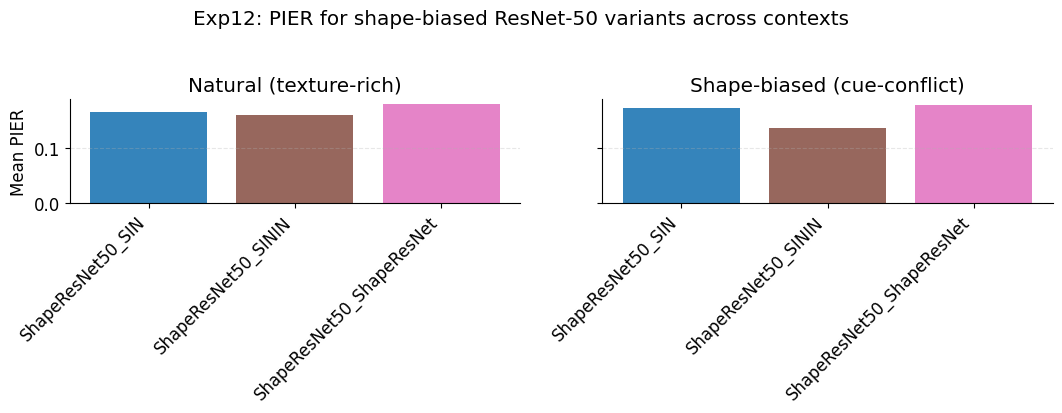

In [12]:
def plot_shape_models_across_variants(df: pd.DataFrame):
    """Focus on the three shape models (A/B/C) and their PIER in natural / shape_bias contexts."""
    shape_names = [
        "ShapeResNet50_SIN",
        "ShapeResNet50_SININ",
        "ShapeResNet50_ShapeResNet",
    ]
    contexts = ["texture_natural", "shape_bias"]

    # Focus on shape models only
    sub = df[df["TargetModel"].isin(shape_names)].copy()
    if sub.empty:
        print("No rows for shape models found.")
        return

    # Aggregate by model + context
    agg = (
        sub.groupby(["TargetModel", "ContextLabel"])["MeanPIER"]
        .mean()
        .reset_index()
    )

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

    for j, ctx in enumerate(contexts):
        ctx_data = agg[agg["ContextLabel"] == ctx].copy()
        ctx_data = order_models(ctx_data)
        models = ctx_data["TargetModel"].tolist()
        vals = ctx_data["MeanPIER"].values

        ax = axes[j]
        x = np.arange(len(models))
        colors = [color_map_models.get(m, "tab:gray") for m in models]
        ax.bar(x, vals, color=colors, alpha=0.9)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha="right")
        ax.set_title(pretty_context.get(ctx, ctx))
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        if j == 0:
            ax.set_ylabel("Mean PIER")

    fig.suptitle("Exp12: PIER for shape-biased ResNet-50 variants across contexts", y=1.03)
    plt.tight_layout()
    plt.show()


plot_shape_models_across_variants(df)


In [13]:
# Simple summary table: MeanPIER by Variant / Context / Model
summary = (
    df.groupby(["ShapeVariant", "ContextLabel", "TargetModel"])["MeanPIER"]
    .mean()
    .reset_index()
)
summary = order_models(summary)
summary.head(20)


,ShapeVariant,ContextLabel,TargetModel,MeanPIER
2,A,shape_bias,ResNet50,0.097111
7,A,texture_natural,ResNet50,0.091702
12,B,shape_bias,ResNet50,0.097110
17,B,texture_natural,ResNet50,0.091707
22,C,shape_bias,ResNet50,0.097111
27,C,texture_natural,ResNet50,0.091708
11,B,shape_bias,EfficientNetB0,0.070341
6,A,texture_natural,EfficientNetB0,0.055704
21,C,shape_bias,EfficientNetB0,0.072952
1,A,shape_bias,EfficientNetB0,0.073668
